In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm


Generate some data to test our procedures. This piece follows the example in https://emcee.readthedocs.io/en/stable/tutorials/line/

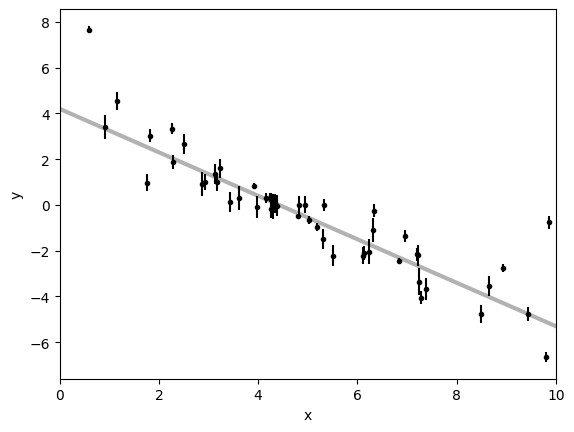

In [2]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.95
b_true = 4.2
f_true = 0.5

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [3]:
np.savetxt('line_data.txt',np.transpose([x,y,yerr]))

Try to find $m$ and $b$ using a Least square method.

> Indented block

> Indented block






In [4]:
A = np.vstack([x, np.ones(len(x))]).T
m_ls, b_ls = np.linalg.lstsq(A, y, rcond=None)[0]
print(m_ls, b_ls)

-0.9705664113016388 4.459014599766696


Now, try to find $m$ and $b$ using a minimum chisq method. 

In [5]:
def line(theta,x):
  m=theta[0]
  b=theta[1]
  return m*x+b

In [6]:
def chisq(theta,data,model):
  model=model(theta,data[0])
  chisq=0.5*np.sum((model-data[1])**2/data[2]**2)
  return chisq
chi2 = lambda *args: chisq(*args)

In [7]:
initial = np.array([-0.8,4])
soln = minimize(chi2, initial, args=([x, y, yerr],line))
m_chi2, b_chi2= soln.x
print(m_chi2, b_chi2)

-1.0811817272832778 5.240374331910024


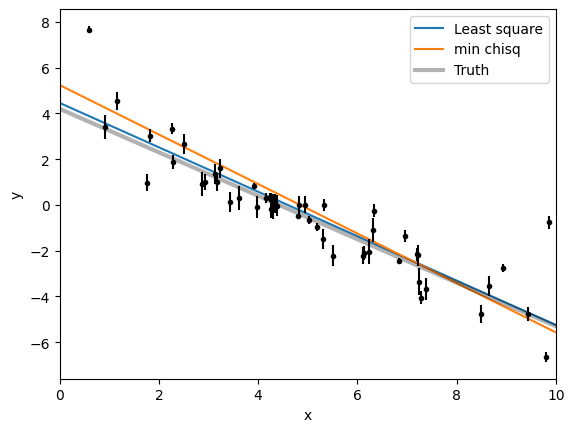

In [8]:
x0 = np.linspace(0, 10, 500)
plt.plot(x0,m_ls*x0+b_ls,label='Least square')
plt.plot(x0,m_chi2*x0+b_chi2, label='min chisq')
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label='Truth')
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

No try to find  $m$ and $b$ using an MCMC Metropolis algorithm. 

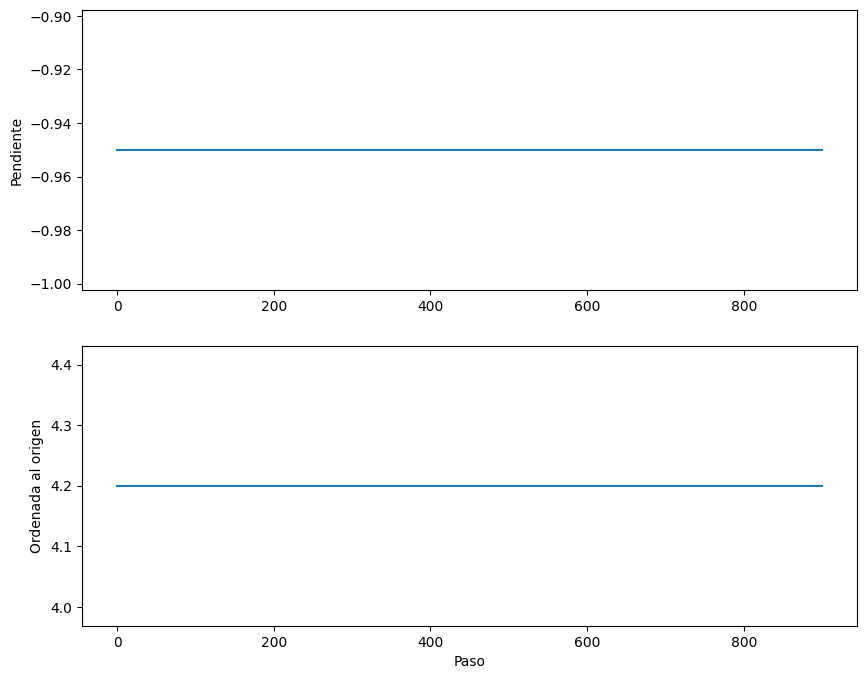

Pendiente más probable: -0.9499999999999997
Ordenada al origen más probable: 4.200000000000001
Fracción de aceptación: 0.9999


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Función para calcular la verosimilitud
def likelihood(x, y, m, b):
    sigma2 = 1.0
    y_model = m * x + b
    L = np.sum(-0.5 * (y - y_model)**2 / sigma2)
    return L

# Función para inicializar la cadena de Markov
def init_chain():
    m = -0.95
    b = 4.2
    return m, b

# Leer datos del archivo
data = np.loadtxt('line_data.txt', delimiter=' ')

# Parámetros de la cadena de Markov
n_steps = 10000
burn_in = 1000
thin = 10
acceptance = 0.0

# Inicializar la cadena de Markov
m_chain = np.zeros(n_steps)
b_chain = np.zeros(n_steps)
log_likelihood = np.zeros(n_steps)

m_chain[0], b_chain[0] = init_chain()
log_likelihood[0] = likelihood(data[:,0], data[:,1], m_chain[0], b_chain[0])

# Ejecutar el algoritmo de Metropolis
for i in range(1, n_steps):
    m_proposal, b_proposal = init_chain()
    log_likelihood_proposal = likelihood(data[:,0], data[:,1], m_proposal, b_proposal)
    log_alpha = log_likelihood_proposal - log_likelihood[i-1]
    if np.log(np.random.uniform()) < log_alpha:
        m_chain[i] = m_proposal
        b_chain[i] = b_proposal
        log_likelihood[i] = log_likelihood_proposal
        acceptance += 1
    else:
        m_chain[i] = m_chain[i-1]
        b_chain[i] = b_chain[i-1]
        log_likelihood[i] = log_likelihood[i-1]

# Descartar los primeros pasos y tomar muestras cada thin
m_chain = m_chain[burn_in::thin]
b_chain = b_chain[burn_in::thin]

# Calcular los valores más probables para la pendiente y la ordenada al origen
m_probable = np.mean(m_chain)
b_probable = np.mean(b_chain)

# Graficar las cadenas de Markov
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(m_chain)
plt.ylabel('Pendiente')
plt.subplot(2, 1, 2)
plt.plot(b_chain)
plt.xlabel('Paso')
plt.ylabel('Ordenada al origen')
plt.show()

# Imprimir los valores más probables
print('Pendiente más probable: {}'.format(m_probable))
print('Ordenada al origen más probable: {}'.format(b_probable))
print('Fracción de aceptación: {}'.format(acceptance / n_steps))



Algorithm for the Metropolis-Hasting MCMC method. 

1.- select $\vec{\theta}_{start}=\vec{\theta}_i$

2.- Propose ￼$\vec{\theta}_{trial}$ from $\mathcal{N}(\vec{\theta}_{i}, \sigma_i)$ 

3.- Compute acceptance probability $p_{acc}=min(1,P(\vec{\theta}_{trial})/P(\vec{\theta}_i))$ where P is the Posterior ( You could use the log of the posterior instead in which case  $p_{acc}=exp(min(0,log(P(\vec{\theta}_{trial})))- log(P(\vec{\theta}_i)))$

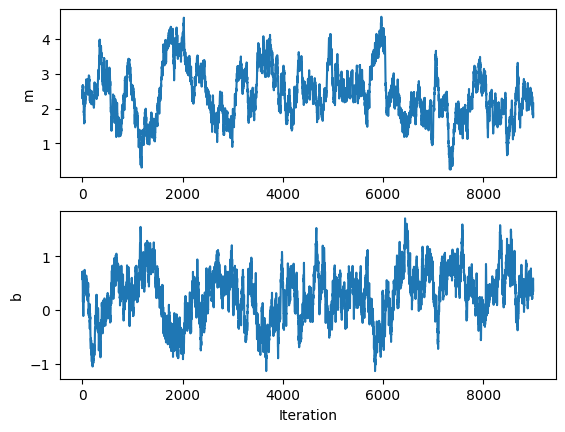

Fracción de aceptación: 0.4391599066562951


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def log_posterior(theta, x, y):
    m, b = theta
    y_pred = m * x + b
    sigma = 1.0
    logp = -0.5 * np.sum(((y - y_pred) / sigma) ** 2)
    return logp

def metropolis_hastings(log_posterior, x, y, n_iterations, proposal_sd):
    n_params = len(initial_theta)
    theta = np.zeros((n_iterations, n_params))
    theta[0] = initial_theta
    log_prob = np.zeros(n_iterations)
    log_prob[0] = log_posterior(theta[0], x, y)

    for i in range(1, n_iterations):
        theta_previous = theta[i-1]
        theta_proposal = np.random.normal(theta_previous, proposal_sd, size=n_params)
        log_prob_proposal = log_posterior(theta_proposal, x, y)

        # Compute acceptance probability
        p_accept = min(1, np.exp(log_prob_proposal - log_prob[i-1]))

        # Accept or reject proposal
        if np.random.rand() < p_accept:
            theta[i] = theta_proposal
            log_prob[i] = log_prob_proposal
        else:
            theta[i] = theta[i-1]
            log_prob[i] = log_prob[i-1]

    return theta, log_prob

# Set up data
m_true = 2.0
b_true = 0.5
x = np.linspace(0, 1, 10)
y = m_true * x + b_true + np.random.randn(len(x)) * 0.2

# Set up initial theta and proposal standard deviation
initial_theta = [0.5, 0.5]
proposal_sd = 0.1

# Run Metropolis-Hastings algorithm
n_iterations = 10000
theta, log_prob = metropolis_hastings(log_posterior, x, y, n_iterations, proposal_sd)

# Plot results
burn_in = 1000
plt.subplot(211)
plt.plot(theta[burn_in:, 0])
plt.ylabel('m')
plt.subplot(212)
plt.plot(theta[burn_in:, 1])
plt.xlabel('Iteration')
plt.ylabel('b')
plt.show()

print('Fracción de aceptación: {}'.format(np.mean(np.diff(log_prob[burn_in:]) > 0)))


In [15]:
data = np.loadtxt('line_data.txt')
x = data[:,0]
y = data[:,1]


In [16]:
def log_posterior(theta, x, y):
    m, b, log_sigma = theta
    y_pred = m * x + b
    log_likelihood = np.sum(norm.logpdf(y, loc=y_pred, scale=np.exp(log_sigma)))
    log_prior = -np.inf if not (-10 < m < 10 and -10 < b < 10 and -10 < log_sigma < 1) else 0
    return log_likelihood + log_prior


In [17]:
def metropolis_hastings(log_posterior, initial_state, n_samples, proposal_sd, burn_in=0):
    # Inicializar el vector de samples y acceptance rate
    samples = [initial_state]
    acceptance = 0
    
    # Iterar sobre las muestras
    for i in range(n_samples):
        current_state = samples[-1]
        
        # Generar una propuesta
        proposal = current_state + norm.rvs(scale=proposal_sd)
        
        # Calcular la probabilidad de aceptación
        log_alpha = log_posterior(proposal, x, y) - log_posterior(current_state, x, y)
        alpha = min(1, np.exp(log_alpha))
        
        # Aceptar o rechazar la propuesta
        if np.random.rand() < alpha:
            samples.append(proposal)
            acceptance += 1
        else:
            samples.append(current_state)
    
    # Calcular el acceptance rate
    acceptance_rate = acceptance / n_samples
    
    return np.array(samples[burn_in:]), acceptance_rate


In [21]:
# Configurar el algoritmo
n_samples = 10000
proposal_sd = 0.1
burn_in = 1000

# Correr el algoritmo
initial_state = np.array([0, 0, 0])
samples, acceptance_rate = metropolis_hastings(log_posterior, initial_state, n_samples, proposal_sd, burn_in)


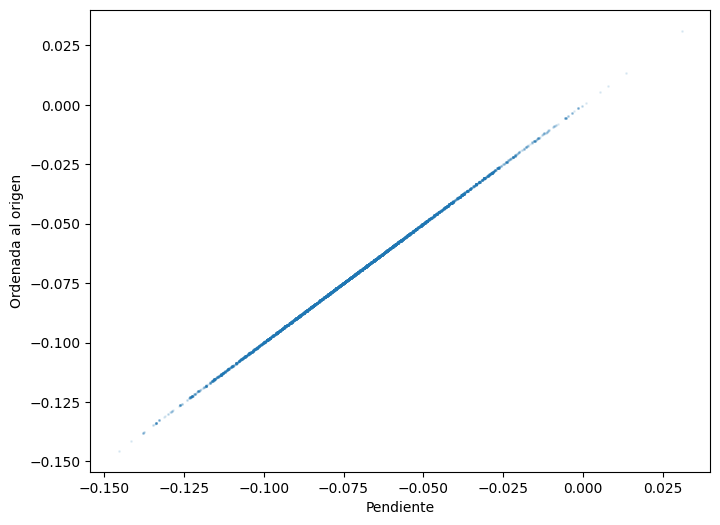

Ordenada al origen: -0.0715740240856048
Pendiente: -0.0715740240856048


In [24]:
# Graficar el posterior conjunto
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(samples[:,0], samples[:,1], s=1, alpha=0.1)
ax.set_xlabel('Pendiente')
ax.set_ylabel('Ordenada al origen')
plt.show()

print('Ordenada al origen: {}'.format(np.mean(samples[:, 0])))
print('Pendiente: {}'.format(np.mean(samples[:, 1])))
